<a href="https://colab.research.google.com/github/afdebbas/DataScience/blob/master/ProjectPVPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
import keras
import pandas as pd
import numpy as np 
from google.colab import files

#modeling
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

# preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#prediction and Classification Report
from sklearn.metrics import explained_variance_score

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_squared_error

from xgboost import plot_importance
from matplotlib import pyplot


In [0]:


uploaded = files.upload()


Saving PlannedValueData.csv to PlannedValueData.csv


# Data Preparation

In [0]:
#Read the file with Email Body part
df=pd.read_csv("PlannedValueData.csv",encoding='utf-8')
df = df.fillna("0")

lb_make = LabelEncoder()
df['ClientName'] = lb_make.fit_transform(df['ClientName'])
df['City'] = lb_make.fit_transform(df['City'])
df['CountryName'] = lb_make.fit_transform(df['CountryName'])
df['ProjectDirectors'] = lb_make.fit_transform(df['ProjectDirectors'])
df['AreaName'] = lb_make.fit_transform(df['AreaName'])
df['ProjectAreaCode'] = lb_make.fit_transform(df['ProjectAreaCode'])

df = df.apply(pd.to_numeric)



In [0]:

y = df.Budgetspentpercentage
x = df.drop('Budgetspentpercentage', axis=1)

train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size=0.25, random_state=87)


In [38]:
#train_X_Scaled = preprocessing.scale(train_X)
#test_X_Scaled = preprocessing.scale(test_X)




[[ 0.87487079  0.47576758  0.27853415 ...  0.66613202  0.57797023
   0.72655378]
 [ 0.52598814  0.0832301   0.10167956 ... -1.20460274 -1.37238214
   0.72655378]
 [-1.21842512  0.11084468  0.88720037 ...  1.39815866  1.39061705
   0.72655378]
 ...
 [-0.86954246 -0.28624428 -0.34082157 ... -1.20460274 -1.37238214
  -1.44275917]
 [ 0.87487079  0.81215742  0.5094479  ...  0.01544166  0.00911745
   0.72655378]
 [-0.86954246 -0.26027358 -0.3108351  ... -0.79792127 -0.47847064
   0.78364097]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [0]:
#Read the file with Email Body part
dfValidation = pd.read_csv("PlannedValueValidationData.csv",encoding='utf-8')
dfValidation = dfValidation.fillna("0")
#dfValidation = dfValidation.drop('ProjectID', axis=1)

dfValidation['ClientName'] = lb_make.fit_transform(dfValidation['ClientName'])
dfValidation['City'] = lb_make.fit_transform(dfValidation['City'])
dfValidation['CountryName'] = lb_make.fit_transform(dfValidation['CountryName'])
dfValidation['ProjectDirectors'] = lb_make.fit_transform(dfValidation['ProjectDirectors'])
dfValidation['AreaName'] = lb_make.fit_transform(dfValidation['AreaName'])
dfValidation['ProjectAreaCode'] = lb_make.fit_transform(dfValidation['ProjectAreaCode'])

dfValidation = dfValidation.apply(pd.to_numeric)

#dfValidation['CPI'].values[:] = 0
#dfValidation['TotalSpent'].values[:] = 0

#dfValidation = dfValidation[dfValidation['ProjectDuration'] == 10]

y_validation = dfValidation.Budgetspentpercentage
x_validation = dfValidation.drop('Budgetspentpercentage', axis=1)


#print(x_validation)

# Modeling - XGBRegressor

In [0]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [ 0.1], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.6],
              'n_estimators': [1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [46]:
train_model = xgb_grid.fit(train_X, train_Y)


print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:  1.2min finished
[Parallel(n_jobs=5)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


0.9647896932788582
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [42]:
pred = train_model.predict(test_X)

print('\nMean Square error" ', mean_squared_error(test_Y,pred))




Mean Square error"  71.93273229798226


# Modeling - TensorFlow

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

In [0]:

y = df.Budgetspentpercentage
x = df.drop('Budgetspentpercentage', axis=1)
#x = df.drop('CPI', axis=1)
#x = df.drop('TotalSpent', axis=1)



In [0]:
seed = 7
test_size = 0.3
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size=test_size, random_state=seed)

In [0]:
# define and fit the final model
def baseline_model():
  
  n_cols = train_X.shape[1]
  
  model = Sequential()
  model.add(Dense(1024, input_dim=n_cols, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  
  return model


In [102]:
filepath="nn_weights-{epoch:02d}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                                             save_weights_only=False, save_best_only=False, mode='max')

early_stop_crit = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                patience=3, verbose=0, mode='auto')
  
model_callbacks = [early_stop_crit]
model_callbacks.append(checkpoint)

model = baseline_model()
history = model.fit(train_X, train_Y, epochs=20, batch_size = 50,  verbose=1, validation_split=0.2, callbacks=model_callbacks)

Train on 72960 samples, validate on 18240 samples
Epoch 1/20
72960/72960 [==============================] - 11s 154us/step - loss: 5764452.9827 - mean_squared_error: 5764452.9827 - mean_absolute_error: 327.5943 - val_loss: 13302074.3946 - val_mean_squared_error: 13302074.3946 - val_mean_absolute_error: 1101.0655
Epoch 2/20
72960/72960 [==============================] - 9s 126us/step - loss: 1965655.5212 - mean_squared_error: 1965655.5212 - mean_absolute_error: 129.2158 - val_loss: 652.5821 - val_mean_squared_error: 652.5821 - val_mean_absolute_error: 12.3997
Epoch 3/20
72960/72960 [==============================] - 9s 126us/step - loss: 17851.3897 - mean_squared_error: 17851.3897 - mean_absolute_error: 24.2796 - val_loss: 60231.8951 - val_mean_squared_error: 60231.8951 - val_mean_absolute_error: 56.7951
Epoch 4/20
72960/72960 [==============================] - 9s 128us/step - loss: 114503.0269 - mean_squared_error: 114503.0269 - mean_absolute_error: 48.7469 - val_loss: 1524.4579 - val_

In [103]:
[history.history['loss'][0:5], history.history['mean_squared_error'][0:5]]

[[5764452.982674381,
  1965655.5212099769,
  17851.389720001764,
  114503.02691698074,
  2123.7878979549073],
 [5764452.982674381,
  1965655.5212099769,
  17851.389720001764,
  114503.02691698074,
  2123.7878979549073]]

In [0]:
temp_test_model  = baseline_model()
test_over_time = []
for i in range(len(history.history['mean_squared_error'])):
    i+=1
    temp_test_model.load_weights("nn_weights-%02d.hdf5" % i)
    scores = temp_test_model.evaluate(test_X, test_Y, verbose=0)
    # 0 is loss; 1 is accuracy
    test_over_time.append(scores)


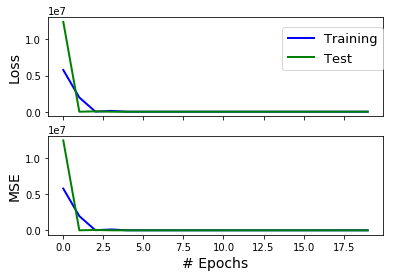

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(history.history['loss'])), history.history['loss'],linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(np.array(test_over_time)[:,0])), np.array(test_over_time)[:,0], linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(history.history['mean_squared_error'])), history.history['mean_squared_error'],linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(np.array(test_over_time)[:,1])), np.array(test_over_time)[:,1], linestyle='-', color='green',label='Test', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
#ax1.set_yscale('log')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('MSE',fontsize=14)
plt.show()

In [0]:
scaler = StandardScaler()

model_scaled = baseline_model()
history_unscaled = model_scaled.fit(scaler.fit_transform(train_X), train_Y, epochs=50, batch_size = 50,  verbose=1, validation_split=0.2, callbacks=model_callbacks, shuffle=True)

TypeError: ignored

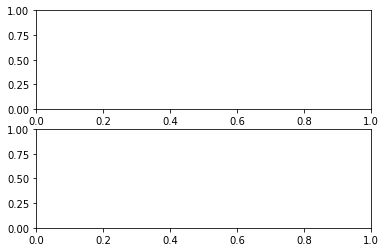

In [109]:

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(history['loss'])), history['loss'], linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(history['val_loss'])), history['val_loss'], linestyle='-', color='purple',label='Validation', lw=2)
ax1.plot(range(len(history['test_loss'])), history['test_loss'],linestyle='-', color='green',label='Test', lw=2)
ax1.plot(range(len(history_scaled['loss'])), history_scaled['loss'], linestyle='-', color='deepskyblue',label='Training (Standardised)', lw=2)
ax1.plot(range(len(history_scaled['val_loss'])), history_scaled['val_loss'], linestyle='-', color='mediumpurple',label='Validation (Standardised)', lw=2)
ax1.plot(range(len(history_scaled['test_loss'])), history_scaled['test_loss'], linestyle='-', color='lightgreen',label='Test (Standardised)', lw=2)
ax2.plot(range(len(history['mean_squared_error'])), history['mean_squared_error'], linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(history['val_mse'])), history['val_mse'], linestyle='-', color='purple',label='Validation', lw=2)
ax2.plot(range(len(history['test_mse'])), history['test_mse'],linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(history_scaled['mean_squared_error'])), history_scaled['mean_squared_error'], linestyle='-', color='deepskyblue',label='Training (Standardised)', lw=2)
ax2.plot(range(len(history_scaled['val_mse'])), history_scaled['val_mse'], linestyle='-', color='mediumpurple',label='Validation (Standardised)', lw=2)
ax2.plot(range(len(history_scaled['test_mse'])), history_scaled['test_mse'], linestyle='-', color='lightgreen',label='Test (Standardised)', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.5, 0.95), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('MSE',fontsize=14)
plt.tight_layout()
plt.show()